Liliana Djaja Witama\
2702219774

# UTS No 2

**Dataset 2B**

**Link video:** https://drive.google.com/file/d/1xu_-gIzeGQ-hn-Bss1GRMt1BgkokGR3z/view?usp=sharing

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
from glob import glob
from tqdm import tqdm
import cv2
from PIL import Image
import shutil

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, EfficientNetB0
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

import random
SEED_VALUE=42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)

## import dataset

In [3]:
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

categories = os.listdir(train_dir)
print("Kategori:", categories)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="training",
    seed=SEED_VALUE,
    label_mode="categorical"  #di-encode pakai one-hot
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.15,
    subset="validation",
    seed=SEED_VALUE,
    label_mode="categorical"
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="categorical"
)

Kategori: ['Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe']
Found 5375 files belonging to 5 classes.
Using 4569 files for training.
Found 5375 files belonging to 5 classes.
Using 806 files for validation.
Found 586 files belonging to 5 classes.


## a. EDA

### histogram warna per kelas

Memproses kelas: Doubtful (1055 gambar)


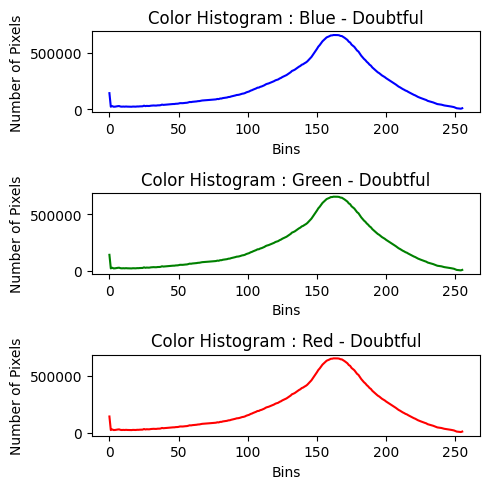

Memproses kelas: Mild (1055 gambar)


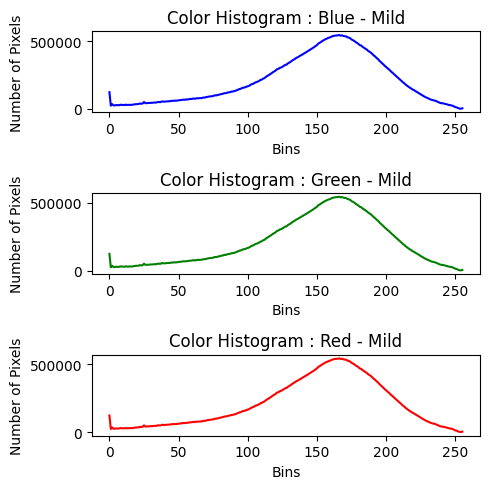

Memproses kelas: Moderate (1155 gambar)


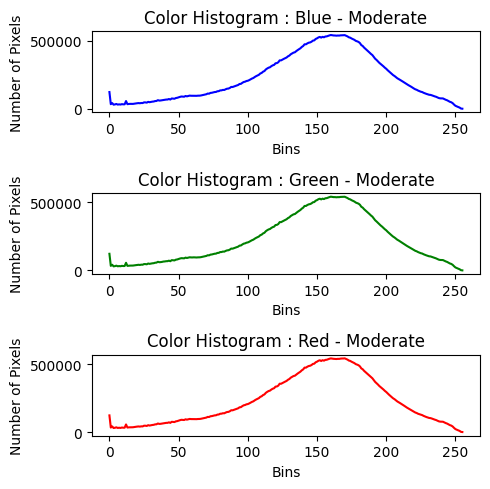

Memproses kelas: Normal (1055 gambar)


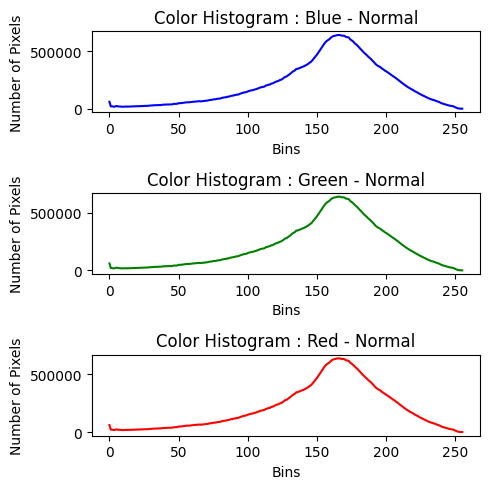

Memproses kelas: Severe (1055 gambar)


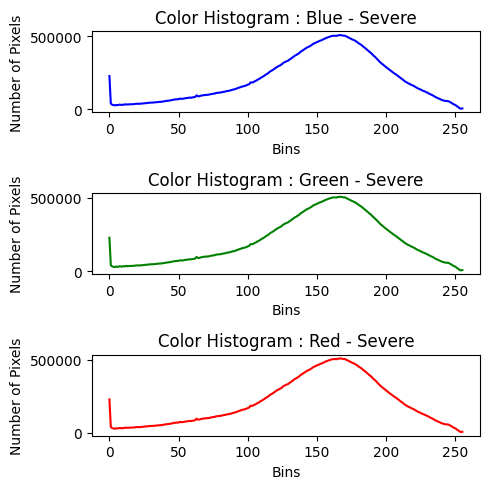

In [4]:
def plot_histogram_kelas(image_paths, class_label):
    total_hist_r = np.zeros(256)
    total_hist_g = np.zeros(256)
    total_hist_b = np.zeros(256)

    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        hist_r = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
        hist_g = cv2.calcHist([img], [1], None, [256], [0, 256]).flatten()
        hist_b = cv2.calcHist([img], [2], None, [256], [0, 256]).flatten()

        total_hist_r += hist_r
        total_hist_g += hist_g
        total_hist_b += hist_b

    plt.figure(figsize=(5,5))

    plt.subplot(3, 1, 1)
    plt.plot(total_hist_b, color='blue')
    plt.title(f'Color Histogram : Blue - {class_label}')
    plt.xlabel('Bins')
    plt.ylabel('Number of Pixels')

    plt.subplot(3, 1, 2)
    plt.plot(total_hist_g, color='green')
    plt.title(f'Color Histogram : Green - {class_label}')
    plt.xlabel('Bins')
    plt.ylabel('Number of Pixels')

    plt.subplot(3, 1, 3)
    plt.plot(total_hist_r, color='red')
    plt.title(f'Color Histogram : Red - {class_label}')
    plt.xlabel('Bins')
    plt.ylabel('Number of Pixels')

    plt.tight_layout()
    plt.show()


for cat in categories:
    image_paths = glob(os.path.join(train_dir, cat, '*.png'))
    print(f"Memproses kelas: {cat} ({len(image_paths)} gambar)")
    plot_histogram_kelas(image_paths, cat)

Distribusi warna biru, hijau, dan merah untuk semua kelas relatif simetris dan berbentuk lonceng (bell-shaped). Untuk semua warna, puncak nilai intensitas berada di sekitar 150-an yang artinya banyak pixel memiliki warna biru, hijau, dan merah sedang (tidak terlalu gelap atau terlalu terang). Mayoritas pixel memiliki intensitas 150an berarti pencahayaan gambar cukup merata sehingga gambar tidak gelap, tapi juga tidak sangat terang.

### aspect ratio & resolution distribution

Processing Doubtful:   0%|          | 0/1055 [00:00<?, ?it/s]

Processing Severe: 100%|██████████| 1055/1055 [00:00<00:00, 1531.69it/s]


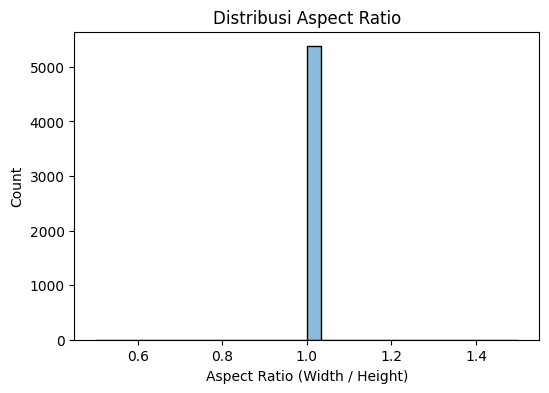

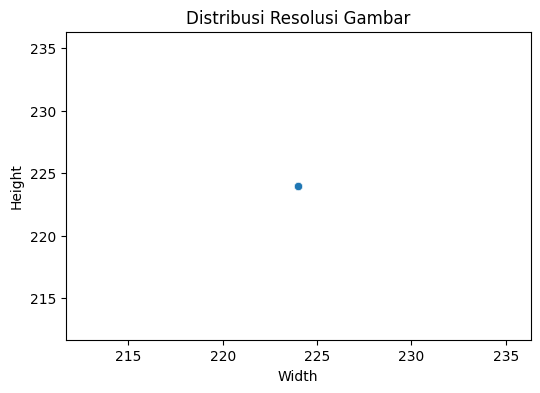

In [5]:
aspect_ratios = []
resolutions = []

for cat in categories:
    paths = glob(os.path.join(train_dir, cat, '*'))
    for path in tqdm(paths, desc=f'Processing {cat}'):
        img = Image.open(path)
        w, h = img.size
        aspect_ratios.append(w / h)
        resolutions.append((w, h))

#plot aspect ratio
plt.figure(figsize=(6,4))
sns.histplot(aspect_ratios, bins=30, kde=True)
plt.title('Distribusi Aspect Ratio')
plt.xlabel('Aspect Ratio (Width / Height)')
plt.show()

#plot resolusi
res_w, res_h = zip(*resolutions)
plt.figure(figsize=(6,4))
sns.scatterplot(x=res_w, y=res_h)
plt.title('Distribusi Resolusi Gambar')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

Aspect ratio yaitu perbandingan antara lebar dan tinggi gambar. Semua gambar memiliki aspect ratio = 1, berarti perbandingannya 1:1 (square).

Plot distribusi resolusi gambar menampilkan bahwa semua gambar memiliki resolusi yang sama, yaitu 224x224.

### Observasi Variabilitas Visual (Lighting, Angle, dll)

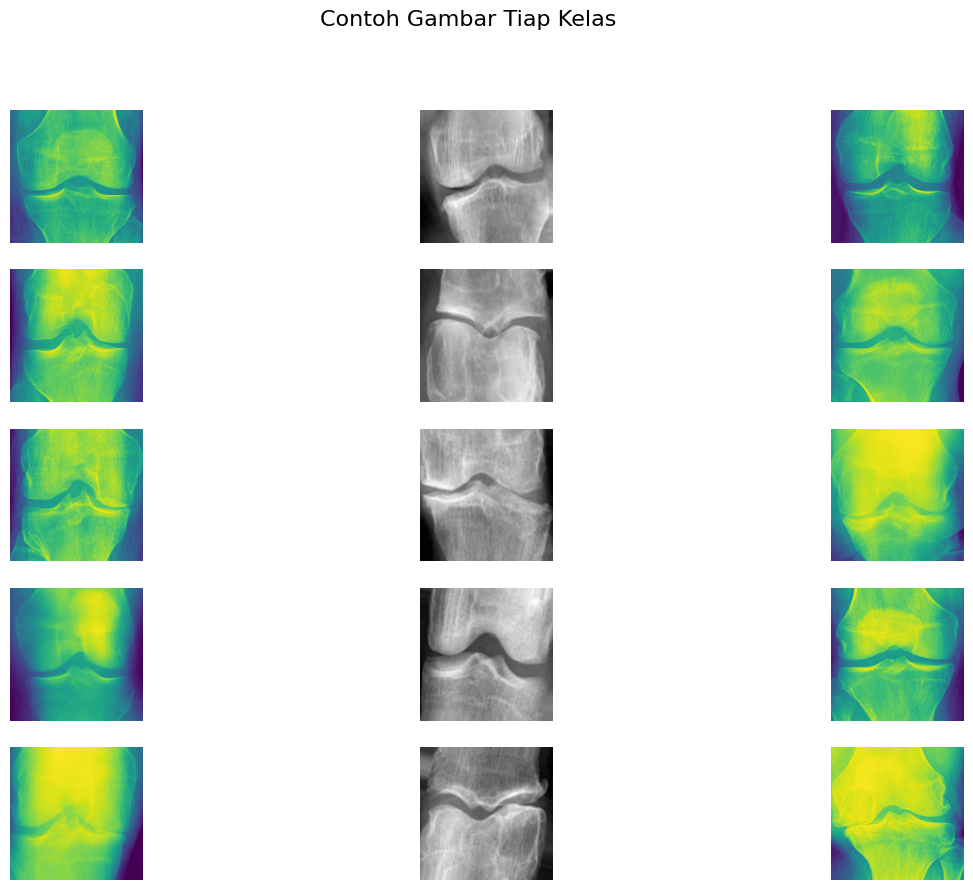

In [ ]:
def observasi(num_images=3):
    plt.figure(figsize=(15, 10))
    for idx, cat in enumerate(categories):
        image_paths = glob(os.path.join(train_dir, cat, '*'))[:num_images]
        for j, path in enumerate(image_paths):
            img = Image.open(path)
            plt.subplot(len(categories), num_images, idx * num_images + j + 1)
            plt.imshow(img)
            plt.axis('off')
            if j == 0:
                plt.ylabel(cat, fontsize=12, color='black')
    plt.suptitle("Contoh Gambar Tiap Kelas", fontsize=16)
    plt.show()

observasi()

Plot di atas menampilkan 3 gambar X-ray lutut per kelas. Gambar ditampilkan dalam grayscale (hitam-putih) dan menggunakan colormap (viridis atau default imshow dari matplotlib). Beberapa hal yang terobservasi yaitu:

1. Lighting\
Beberapa gambar terlihat lebih terang atau lebih gelap dari yang lain, meskipun berasal dari kelas yang sama. Hal ini menandakan inkonsistensi pencahayaan (lighting) saat pengambilan gambar X-ray.

2. Angle\
Posisi lutut ada yang sedikit miring. Gambar juga tidak selalu berada di tengah.

3. Noise\
Beberapa gambar terlihat agak kabur atau tidak fokus, bisa jadi karena resolusi gambar rendah.

### EDA Conclusion
Pada dataset ini terdapat 5 kelas osteoarthritis: Doubtful, Mild, Moderate, Normal, dan Severe. Dataset train terdiri dari 5375 gambar yang kemudian diambil 15%nya menjadi data validation sehingga 4569 gambar digunakan untuk training dan 806 gambar digunakan untuk validation. Dataset test memiliki  586 gambar.

Setelah melakukan EDA, ditemukan bahwa distribusi warna biru, hijau, dan merah untuk semua kelas relatif simetris dan nilai intensitas berada di sekitar 150-an yang artinya banyak pixel memiliki warna biru, hijau, dan merah sedang (tidak terlalu gelap atau terlalu terang). Pencahayaan gambar cukup merata sehingga gambar tidak gelap, tapi juga tidak sangat terang.

Semua gambar ditemukan memiliki aspect ratio = 1 dan semua gambar memiliki resolusi yang sama, yaitu 224x224.

Berdasarkan observasi terhadap variabilitas pada gambar, ditemukan beberapa hal, yaitu adanya inkonsistensi pencahayaan (lighting) saat pengambilan gambar X-ray, posisi lutut ada yang sedikit miring dan gambar juga tidak selalu berada di tengah, serta beberapa gambar terlihat agak kabur atau tidak fokus.

## Preprocessing

### resize gambar

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)), y))
val_ds = val_ds.map(lambda x, y: (tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)), y))

melakukan resize gambar supaya ukuran tetap dan konsisten dan sesuai dengan requirement arsitektur model yang dipakai (AlexNet, DenseNet, dan EfficientNet).

## b. Model AlexNet

In [ ]:
callbacks_model = [
    keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

Callback dieksekusi secara otomatis saat training pada akhir setiap epoch. Fungsi callback di atas berguna untuk menyimpan model terbaik selama training, menghentikan training secara otomatis jika model tidak membaik setelah beberapa 5 epoch berturut-turut, menurunkan learning rate sebanyak setengah kali saat model tidak membaik dalam 3 epoch berturut-turut. Pengaplikasian callback bisa mengurangi risiko overfitting, learning rate yang stagnan, dan lebih efisien waktu dan resource.

In [55]:
input_layer = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = Conv2D(96, (11,11), strides=4, activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(3,3), strides=2)(x)

x = Conv2D(256, (5,5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides=2)(x)

x = Conv2D(384, (3,3), padding='same', activation='relu')(x)
x = Conv2D(384, (3,3), padding='same', activation='relu')(x)
x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3,3), strides=2)(x)

x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(5, activation='softmax')(x)

model_alexnet = Model(inputs=input_layer, outputs=output_layer)
model_alexnet.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 54, 54, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 26, 26, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 26, 26, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,767,493 (178.40 MB)

 Trainable params: 46,767,493 (178.40 MB)

 Non-trainable params: 0 (0.00 B)

**Penjelasan model**\
Model ini menerima gambar berwarna dengan 3 kanal (RGB), jadi dimensi inputnya adalah gambar 2D dengan 3 saluran warna.

Convolutional layer 1 memiliki 96 filter dengan ukuran kernel (11, 11). Stride = 4 berarti filter akan bergerak dengan langkah 4 pixel. Activation function yang digunakan yaitu ReLU. Fungsi layer ini adalah untuk mengekstraksi fitur dasar seperti tepi dan tekstur dari gambar.

Max pooling layer 1 memiliki pool size (3, 3), yang berarti ukuran jendela pooling adalah 3x3 dengan stride = 2. layer ini akan mengurangi dimensi gambar dan mengurangi jumlah parameter, serta mengekstrak fitur penting dari gambar.

Convolutional layer 2 memiliki 256 filter dengan ukuran kernel (5, 5). Padding = 'same', yang berarti dimensi output dari layer ini akan sama dengan dimensi input, setelah melakukan padding di pinggir gambar jika diperlukan. Activation function yang digunakan yaitu ReLU. Fungsi layer ini adalah untuk mengekstraksi fitur yang lebih kompleks.

Max pooling layer 2 sama seperti max pooling layer 1.

Dilanjutkan dengan tiga convolution layer berturut-turut dengan jumlah filter berbeda, yaitu 384, 384, dan 256. Setiap layer bertujuan untuk menangkap fitur tingkat tinggi seperti bentuk objek dan pola yang lebih kompleks.

Max pooling layer 3 sama seperti max pooling layer 1.

Flatten layer mengubah output dari tensor 2D menjadi bentuk vektor 1D sehingga bisa dimasukkan ke lapisan dense berikutnya.

Fully connected layer 1 memiliki 4096 neuron dan menggunakan activation function ReLU. Layer ini berfungsi untuk menggabungkan fitur yang diekstraksi sebelumnya menjadi representasi yang lebih abstrak.

Dropout 0.5 digunakan untuk mengurangi overfitting dengan secara acak menonaktifkan 50% neuron selama pelatihan.

Fully connected layer 1 sama seperti fully connected layer 2.

Dropout.

Output layer memiliki 5 neuron untuk klasifikasi 5 kelas 
(Doubtful, Mild, Moderate, Normal, dan Severe) dan menggunakan activation Softmax untuk klasifikasi multi-kelas.

In [56]:
model_alexnet.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [58]:
history_alexnet = model_alexnet.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks_model
)

Epoch 1/100


143/143 ━━━━━━━━━━━━━━━━━━━━ 78s 545ms/step - accuracy: 0.2070 - loss: 1.6102 - val_accuracy: 0.2221 - val_loss: 1.6058 - learning_rate: 0.0010
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 87s 608ms/step - accuracy: 0.2086 - loss: 1.6083 - val_accuracy: 0.1774 - val_loss: 1.6108 - learning_rate: 0.0010
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 79s 536ms/step - accuracy: 0.2123 - loss: 1.6070 - val_accuracy: 0.2208 - val_loss: 1.6142 - learning_rate: 0.0010
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 504ms/step - accuracy: 0.2097 - loss: 1.6121 - val_accuracy: 0.2258 - val_loss: 1.6100 - learning_rate: 0.0010
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 73s 510ms/step - accuracy: 0.2082 - loss: 1.6105 - val_accuracy: 0.2047 - val_loss: 1.6210 - learning_rate: 0.0010
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 729ms/step - accuracy: 0.2154 - loss: 1.6086 - val_accuracy: 0.2246 - val_loss: 1.6270 - learning_rate: 0.0010
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 84s 588ms/step - accuracy: 0.2047 

Dari hasil pelatihan model AlexNet yang kamu tampilkan selama 20 epoch, dapat dilihat bahwa model belum belajar dengan baik.

Accuracy dan val_accuracy konsisten berada di kisaran 0.20 – 0.23. Ini menandakan bahwa model belum belajar pola signifikan dari data.

Baik training loss (loss) maupun validation loss (val_loss) hanya berubah sedikit selama epoch, bahkan kadang naik turun. Ini menunjukkan model stuck, atau bisa jadi learning rate terlalu kecil atau terlalu besar di awal.

Dari epoch ke-7, learning rate turun dari 0.001 ke 0.0005 ke 0.00025.

## c. Tuning menggunakan model EfficientNetB0

Saya ingin membandingkan performa model AlexNet dengan EfficientNet pada dataset Osteoarthritis untuk mengetahui mana yang lebih baik. EfficientNet yang menggunakan compound scaling terbukti lebih general dan stabil pada banyak dataset, termasuk yang kecil seperti dataset radiologi/medis. Di sini saya juga menggunakan arsitektur yang sama (include_top=False + GlobalAveragePooling2D + Dense(512) + softmax(5)) serta optimizer dan loss function yang sama sehingga perbandingan antara kedua model bisa seobjektif mungkin.

In [41]:
callbacks_model_effnet = [
    keras.callbacks.ModelCheckpoint('best_model_effnet.keras', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

In [43]:
base_effnet = EfficientNetB0(weights=None, include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_effnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model_effnet = Model(inputs=base_effnet.input, outputs=output)
model_effnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_effnet.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_1[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization_1[… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 4,708,008 (17.96 MB)

 Trainable params: 4,665,985 (17.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

EfficientNetB0 di sini digunakan sebagai feature extractor, tetapi saya tidak menggunakan pretrained weights (ImageNet).

GlobalAveragePooling2D menggantikan Flatten. Ini lebih efisien, dan membantu mengurangi jumlah parameter untuk mencegah overfitting.

Tambahan fully-connected layer dengan 512 unit dan ReLU yang memungkinkan model belajar kombinasi fitur-fitur dari EfficientNet untuk tugas klasifikasimu.

Layer output memiliki jumlah neuron = 5 (sesuai jumlah kelas) dan menggunakan aktivasi softmax karena untuk case multi-class classification.

In [44]:
history_effnet = model_effnet.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=callbacks_model_effnet
)

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 519s 3s/step - accuracy: 0.2529 - loss: 1.6216 - val_accuracy: 0.1985 - val_loss: 1.6374 - learning_rate: 1.0000e-04
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 409s 3s/step - accuracy: 0.2687 - loss: 1.5739 - val_accuracy: 0.1985 - val_loss: 1.6998 - learning_rate: 1.0000e-04
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.3049 - loss: 1.5262 - val_accuracy: 0.1998 - val_loss: 1.7196 - learning_rate: 1.0000e-04
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.3474 - loss: 1.4644 - val_accuracy: 0.2767 - val_loss: 1.5799 - learning_rate: 1.0000e-04
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.3996 - loss: 1.3584 - val_accuracy: 0.3201 - val_loss: 1.5049 - learning_rate: 1.0000e-04
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.4785 - loss: 1.2438 - val_accuracy: 0.3474 - val_loss: 1.5333 - learning_rate: 1.0000e-04
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/ste

Train accuracy naik terus dari 0.26 ke 0.67 dan train loss turun terus dari 1.6 ke 0.8.

Sedangkan validation accuracy terlihat naik di epoch 1-6, tetapi mulai epoch 7 stagnan di 0.3. Validation loss terlihat turun di epoch 1-6 tetapi malah naik drastis di epoch 7 dan terlihat tidak stabil hingga epoch 10.

Hasil ini menunjukkan adanya overfitting karena training accuracy tinggi tetapi validation accuracy stagnan.

## Testing

In [29]:
def evaluate_model(model, dataset, dataset_name, class_names):
    y_pred_probs = model.predict(dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.concatenate([np.argmax(label.numpy(), axis=1) for _, label in dataset], axis=0)

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    print(f"\nConfusion Matrix for {dataset_name}:")
    print(confusion_matrix(y_true, y_pred))

    return {
        "Model": dataset_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }


In [27]:
class_names = sorted(os.listdir(test_dir))

In [59]:
result_alexnet = evaluate_model(model_alexnet, test_ds, "AlexNet", class_names)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step

Classification Report for AlexNet:
              precision    recall  f1-score   support

    Doubtful       0.00      0.00      0.00       117
        Mild       0.00      0.00      0.00       117
    Moderate       0.20      0.99      0.33       117
      Normal       0.00      0.00      0.00       118
      Severe       0.50      0.02      0.03       117

    accuracy                           0.20       586
   macro avg       0.14      0.20      0.07       586
weighted avg       0.14      0.20      0.07       586


Confusion Matrix for AlexNet:
[[  0   0 116   0   1]
 [  0   0 116   0   1]
 [  0   1 116   0   0]
 [  0   0 118   0   0]
 [  0   0 115   0   2]]


C:\Users\lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lenovo\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Kelas Doubtful memiliki skor precision 0 yang berarti 0% dari pasien yang diprediksi sebagai Doubtful sebenarnya merupakan Doubtful. Skor recall sebesar 0 berarti 0% dari kelas Doubtful diidentifikasi dengan benar. f1 score sebesar 0 berarti model memiliki performa yang buruk dalam mmengidentifikasi pasien Doubtful dengan benar.

Kelas Mild memiliki skor precision 0 yang berarti 0% dari pasien yang diprediksi sebagai Mild sebenarnya merupakan Mild. Skor recall sebesar 0 berarti 0% dari kelas Mild diidentifikasi dengan benar. f1 score sebesar 0 berarti model memiliki performa yang buruk dalam mmengidentifikasi pasien Mild dengan benar.

Kelas Moderate memiliki skor precision 0.2 yang berarti 20% dari pasien yang diprediksi sebagai Moderate sebenarnya merupakan Moderate. Skor recall sebesar 0.99 berarti 99% dari kelas Moderate diidentifikasi dengan benar. f1 score sebesar 0.33 berarti model memiliki performa yang buruk dalam mmengidentifikasi pasien Moderate dengan benar.

Kelas Normal memiliki skor precision 0 yang berarti 0% dari pasien yang diprediksi sebagai Normal sebenarnya merupakan Normal. Skor recall sebesar 0 berarti 0% dari kelas Normal diidentifikasi dengan benar. f1 score sebesar 0 berarti model memiliki performa yang buruk dalam mmengidentifikasi pasien Normal dengan benar.

Kelas Severe memiliki skor precision 0.5 yang berarti 50% dari pasien yang diprediksi sebagai Severe sebenarnya merupakan Severe. Skor recall sebesar 0.02 berarti 2% dari kelas Severe diidentifikasi dengan benar. f1 score sebesar 0.03 berarti model memiliki performa yang buruk dalam mmengidentifikasi pasien Severe dengan benar.

**Overall**\
Secara keseluruhan, model memiliki akurasi sebesar 20%. Hal ini berarti, model memiliki performa yang buruk dalam mengidentifikasi kelas-kelas Osteoarthritis.

In [49]:
result_effnet = evaluate_model(model_effnet, test_ds, "EfficientNet", class_names)

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 331ms/step

Classification Report for EfficientNet:
              precision    recall  f1-score   support

    Doubtful       0.33      0.03      0.05       117
        Mild       0.20      0.01      0.02       117
    Moderate       0.21      0.80      0.33       117
      Normal       0.23      0.19      0.21       118
      Severe       0.22      0.04      0.07       117

    accuracy                           0.21       586
   macro avg       0.24      0.21      0.13       586
weighted avg       0.24      0.21      0.13       586


Confusion Matrix for EfficientNet:
[[ 3  0 90 20  4]
 [ 1  1 89 21  5]
 [ 1  0 94 15  7]
 [ 2  1 91 22  2]
 [ 2  3 89 18  5]]


Kelas Doubtful memiliki skor precision 0.33 yang berarti 33% dari pasien yang diprediksi sebagai Doubtful sebenarnya merupakan Doubtful. Skor recall sebesar 0.03 berarti 3% dari kelas Doubtful diidentifikasi dengan benar. f1 score sebesar 0.05 berarti model memiliki performa yang buruk dalam mmengidentifikasi pasien Doubtful dengan benar.

Kelas Mild memiliki skor precision 0.2 yang berarti 20% dari pasien yang diprediksi sebagai Mild sebenarnya merupakan Mild. Skor recall sebesar 0.01 berarti 1% dari kelas Mild diidentifikasi dengan benar. f1 score sebesar 0.02 berarti model memiliki performa yang buruk dalam mmengidentifikasi pasien Mild dengan benar.

Kelas Moderate memiliki skor precision 0.21 yang berarti 21% dari pasien yang diprediksi sebagai Moderate sebenarnya merupakan Moderate. Skor recall sebesar 0.80 berarti 80% dari kelas Moderate diidentifikasi dengan benar. f1 score sebesar 0.33 berarti model memiliki performa yang buruk dalam mmengidentifikasi pasien Moderate dengan benar.

Kelas Normal memiliki skor precision 0.23 yang berarti 23% dari pasien yang diprediksi sebagai Normal sebenarnya merupakan Normal. Skor recall sebesar 0.19 berarti 19% dari kelas Normal diidentifikasi dengan benar. f1 score sebesar 0.21 berarti model memiliki performa yang buruk dalam mmengidentifikasi pasien Normal dengan benar.

Kelas Severe memiliki skor precision 0.22 yang berarti 22% dari pasien yang diprediksi sebagai Severe sebenarnya merupakan Severe. Skor recall sebesar 0.04 berarti 4% dari kelas Severe diidentifikasi dengan benar. f1 score sebesar 0.07 berarti model memiliki performa yang buruk dalam mmengidentifikasi pasien Severe dengan benar.

**Overall**\
Secara keseluruhan, model memiliki akurasi sebesar 21%. Hal ini berarti, model memiliki performa yang buruk dalam mengidentifikasi kelas-kelas Osteoarthritis.

In [70]:
results_df = pd.DataFrame([result_alexnet, result_effnet])
print(results_df)

          Model  Accuracy  Precision    Recall  F1 Score
0       AlexNet  0.201365   0.139692  0.201365  0.072962
1  EfficientNet  0.213311   0.237465  0.213311  0.134297


Berdasarkan tabel perbandingan tersebut, dapat dilihat bahwa model EfficientNet unggul di semua metrics dibandingkan dengan model AlexNet. Artinya, model EfficientNet lebih akurat dalam memprediksi label, lebih sedikit salah label (higher precision), mampu menangkap lebih banyak instance yang benar (higher recall), dan F1 score yang hampir 2x lebih baik dari AlexNet menunjukkan trade-off precision-recall yang lebih seimbang.

## Conclusion
Meskipun model EfficientNet lebih unggul, tetapi hasil kedua model masih buruk. Akurasi kedua model masih di sekitar 20% yang menunjukkan model hanya melakukan random guess dan belum melakukan generalisasi.